# Using K Means to Identify Fraud in Medicare Transaction
 Author: Anderson Nelson <br>
 Date: 10/13/2019 <br>

In [1]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("error", message=".*check_inverse*.",
                        category=UserWarning, append=False)

## Introduction

The data was obtained from Data.CMS and provides information on inpatient discharges for Medicare fee-for-service beneficiaries. The Inpatient PUF includes information on utilization, payment (total payment and Medicare payment), and hospital-specific charges for the more than 3,000 U.S. hospitals that receive Medicare Inpatient Prospective Payment System (IPPS) payments. 

The goal of this project is to apply feature engineering techniques discussed in various machine learning papers to create new variables that make business sense while also capturing incremental variance in the data. Also, to identify potential fraudulent providers using the K-Mean algorithm.



In [2]:
# read data 
charge_data = pd.read_csv('../Data/inpatientCharges.csv')

# remove white space in 
charge_data = charge_data.rename(columns=lambda x: x.strip())

# drop useless columns 
charge_data = charge_data.drop(columns = ['Provider Street Address'])

charge_data.head()

,DRG Definition,Provider Id,Provider Name,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44


In [3]:
# Constant Names 
drg_defination_name ='DRG Definition'
provider_name = 'Provider Name'
prodiver_id_name = 'Provider Id'
proder_address_name = 'Provider Street Address'
provider_city_name = 'Provider City'
provider_state_name = 'Provider State'
provider_zip_code_name = 'Provider Zip Code'
hospital_referal_name = 'Hospital Referral Region Description'
total_discharges_name = 'Total Discharges'
average_covered_charges_name = 'Average Covered Charges'
average_total_payment_name = 'Average Total Payments'
average_medicare_payment = 'Average Medicare Payments'
region_name = 'Region'
division_name = 'Division'

## Feature Engineering

The values contained in the data can be influenced by numerous compounding variables such as population, number of providers, state laws.  My approach was to reformulate those variables in a format that can be standardized for comparison. I considered Region, State, City Region, and Zipcode. 
-	Region: Too broad 
-	State: Doesn’t capture the distinction between rural and urban from a population standpoint. The results can positively or negatively impact the values 
-	Zipcode: Some zip codes contained too little observations


The best option was to standardize using City Region.The class discussion provided great insight into feature engineering and provided a framework to guide my thinking. I kept a handful of the features and created a variety of new ones.   


In [4]:
unique_id =  len(charge_data.groupby('Provider Id').count())
unique_providers = len(charge_data.groupby('Provider Name').count())
unique_cities = len(charge_data.groupby('Provider City').count())

print(f'There are {unique_id} unique provider id values in the data, and {unique_providers} unique providers in {unique_cities} unique cities' )

# remove $ sign from co
charge_data['Average Covered Charges'] = charge_data['Average Covered Charges'].str.strip("$")
charge_data['Average Total Payments'] = charge_data['Average Total Payments'].str.strip("$")
charge_data['Average Medicare Payments'] = charge_data['Average Medicare Payments'].str.strip("$")

# conver to numeric 
charge_data[['Average Covered Charges','Average Total Payments','Average Medicare Payments']] = charge_data[['Average Covered Charges','Average Total Payments','Average Medicare Payments']].apply(pd.to_numeric)

There are 3337 unique provider id values in the data, and 3201 unique providers in 1977 unique cities


In [5]:
charge_data['Out of Pocket Payment'] = charge_data[average_total_payment_name] - charge_data[average_medicare_payment]
charge_data['Coverage Ratio'] = charge_data[average_covered_charges_name] / charge_data[average_total_payment_name]
charge_data['Out of Pocket per discharge'] = charge_data['Out of Pocket Payment'] / charge_data[total_discharges_name]
charge_data['Payment Covered Percentage'] = charge_data[average_total_payment_name] / charge_data[average_covered_charges_name]
charge_data['Medicare % Paid']  = charge_data[average_medicare_payment] / charge_data[average_total_payment_name] 

In [6]:
drg_hosp_region_avg = charge_data.groupby([drg_defination_name, hospital_referal_name]).agg(mean_discharge_per_drg_state_region = pd.NamedAgg(column = total_discharges_name, aggfunc=np.mean),
                                                                  mean_covered_charges_per_drg_state_region = pd.NamedAgg(column = average_covered_charges_name, aggfunc=np.mean),
                                                                  mean_total_payments_per_drg_state_region = pd.NamedAgg(column = average_total_payment_name, aggfunc=np.mean),
                                                                  mean_medicare_payments_per_drg_state_region = pd.NamedAgg(column = average_medicare_payment, aggfunc=np.mean),
                                                                  mean_trans_per_drg_state_region = pd.NamedAgg(column = average_medicare_payment, aggfunc='count'),
                                                                                                   
                                                                  mean_oop_drg_state_region = pd.NamedAgg(column = 'Out of Pocket Payment', aggfunc=np.mean),
                                                                  mean_oop_per_discharge_drg_state_region = pd.NamedAgg(column = 'Out of Pocket per discharge', aggfunc=np.mean),
                                                                  mean_pmt_cov_pct_drg_state_region = pd.NamedAgg(column = 'Payment Covered Percentage', aggfunc=np.mean),
                                                                  mean_medicare_paid_state_region = pd.NamedAgg(column = 'Medicare % Paid', aggfunc=np.mean),
                                                                 )

charge_data_1 = pd.merge(left=charge_data, right=drg_hosp_region_avg, on= [drg_defination_name, hospital_referal_name], how='left')

In [7]:
# Append the average statistics back to the data to derive the ratios.
charge_data_1['total_discharge_ratio'] = charge_data_1[total_discharges_name] / charge_data_1['mean_discharge_per_drg_state_region']
charge_data_1['ratio_average_covered_charges'] = charge_data_1[average_covered_charges_name] / charge_data_1['mean_covered_charges_per_drg_state_region']
charge_data_1['ratio_average_total_payment'] = charge_data_1[average_total_payment_name] / charge_data_1['mean_total_payments_per_drg_state_region']
charge_data_1['ratio_average_medicare_payments'] = charge_data_1[average_medicare_payment] / charge_data_1['mean_medicare_payments_per_drg_state_region']

charge_data_1['ratio_oop_payment'] = charge_data_1['Out of Pocket Payment'] / charge_data_1['mean_oop_drg_state_region']
charge_data_1['ratio_oop_payment_ratio'] = charge_data_1['Out of Pocket per discharge'] / charge_data_1['mean_oop_per_discharge_drg_state_region']
charge_data_1['ratio_payment_coverage'] = charge_data_1['Payment Covered Percentage'] / charge_data_1['mean_pmt_cov_pct_drg_state_region']
charge_data_1['ratio_medicare_pct_paid'] = charge_data_1['Medicare % Paid'] / charge_data_1['mean_pmt_cov_pct_drg_state_region']


In [8]:
medicare_perct_paid_by_hosp_region = charge_data_1.groupby([drg_defination_name,hospital_referal_name]).agg(region_avg_medicare_paid = pd.NamedAgg('Medicare % Paid','mean'))

### Features Created: 

The goal of the create features fall within one of the following ratinale: 

The goal of the created features fall within one of the following rationales:

1)	Capture the ERG average per hospital region. The assumption is that there is a standard cost for ERG at the regional level. Those features would highlight the degree difference between hospitals for the same operation. Those hospitals with more substantial disparity would need to be investigated further to understand the charged gap. Since the medicare % coverage is 80% 

2)	 Features calculated to serve as a deterrent for wrongdoing from a patient standpoint. For example, those with high costs to the consumer or patient. The hypothesis is that the patient would file a dispute against the hospital for those charges, which brings attention to the hospital 




1. **Out of Pocket Payment**
2. **Coverage Ratio**
3. **Out of Pocket per discharge**
4. **Payment Covered Percentage**
5. **Total Discharge Ratio**
6. **Medicare % Paid**
7. **Mean discharge per DRG State Region**
8. **Mean Covered Charges per DRG State Region**
9. **Mean Dischage per DRG State Region**
10. **Mean Covered Charges per DRG State Region**
11. **Mean Total Payment per DRG State Region**
12. **Mean Medicare Payment per DRG State Region**
13. **Mean trans per DRG State Region**
14. **Mean Out of Pocker per DRG State Region**
15. **Mean Payment cov percentage per DRG state region**
16. **Median Medicare Paid per state region**
17. **Total Discharge Ratio to Average Covered Charges**
18. **Ratio: Average Total Payment  to Average Medicare Payments**
19. **Ratio: Out of Pocket Payment Ration**
20. **Ratio: Payment Coverage ratio over Medicare % paid**
21. **Ratio: Region avg medicare paid to  medicare paid**


In [9]:
charge_data_2 = pd.merge(left=charge_data_1, right= medicare_perct_paid_by_hosp_region, on=[drg_defination_name,hospital_referal_name],how= 'left')
charge_data_2['Medicare Paid Ratio'] = charge_data_2['Medicare % Paid'] /charge_data_2['region_avg_medicare_paid']
charge_data_2.head()

,DRG Definition,Provider Id,Provider Name,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,...,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_average_medicare_payments,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,region_avg_medicare_paid,Medicare Paid Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,...,1.338235,0.908445,1.037810,1.038763,1.033356,0.691641,1.128919,5.311252,0.823783,1.000954
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,...,0.509804,0.376065,1.008540,1.080948,0.714704,1.274242,1.873207,4.211412,0.804224,1.069224
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,...,0.873950,0.933470,0.947092,0.967369,0.864809,0.899420,0.708675,4.013431,0.804224,1.018959
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,...,0.910364,0.347893,0.944062,0.896859,1.135614,1.133822,1.895443,3.732842,0.804224,0.947721
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,...,0.655462,0.786167,0.986018,1.053739,0.711205,0.986225,0.876044,4.199175,0.804224,1.066118


## Feature Reduction 

The goal of feature engineering is to create data that will directly influence the predictive models' results. Having great features that describe the structures inherent in your data can significantly improve the result of the model. In this case, the newly created may or may not improve the performance of the model; we need to find a way to reduce the features and highlight only those with predictive power. Unfortunately, not all the features that make business sense improves the predictability of the model. Our job is filter all those variables and select the best ones. 

Given that our problem is unsupervised, the methods to reduce features shink. Dimensionality reduction is an excellent method to discover which a combination of variables captures the variance in the model. However, it loses variable interpretability. 

By creating a correlation chart, we can visualize the correlated variables in the data. 

The visualization indicates that there is a number of variables that are correlated. Correlated features, in general, don't improve models.




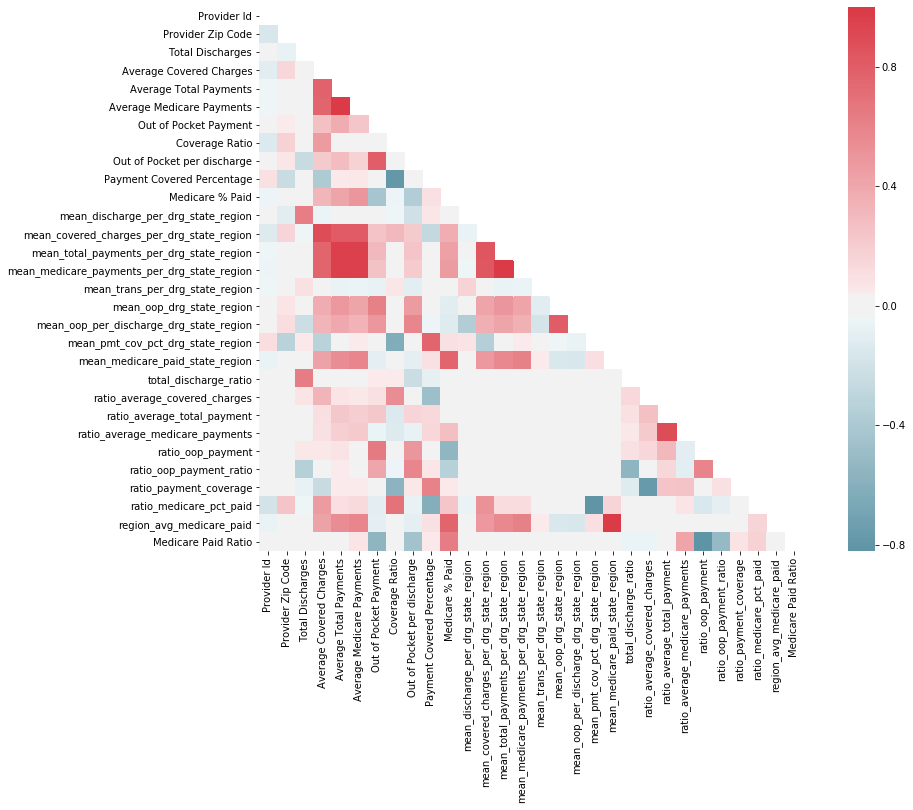

In [10]:
fig = plt.figure(figsize=(16,10))

corr = charge_data_2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True)
plt.show()

## Scaling Data

We saw that there are several highly correlated features. Are those features still correlated after being scaled? 

Since the K means algorithm calculates the Euclidean distance between two variables, the algorithm only takes the magnitude of the features and ignores the unit. Elements with high magnitudes will have a more substantial effect than the ones with low magnitude. 

In [11]:
k_means_data = charge_data_2.iloc[:,7:]
k_means_data.head()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,...,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_average_medicare_payments,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,region_avg_medicare_paid,Medicare Paid Ratio
0,91,32963.07,5777.24,4763.73,1013.51,5.705678,11.137473,0.175264,0.824568,68.000000,...,1.338235,0.908445,1.037810,1.038763,1.033356,0.691641,1.128919,5.311252,0.823783,1.000954
1,14,15131.85,5787.57,4976.71,810.86,2.614543,57.918571,0.382476,0.859896,27.461538,...,0.509804,0.376065,1.008540,1.080948,0.714704,1.274242,1.873207,4.211412,0.804224,1.069224
2,24,37560.37,5434.95,4453.79,981.16,6.910895,40.881667,0.144699,0.819472,27.461538,...,0.873950,0.933470,0.947092,0.967369,0.864809,0.899420,0.708675,4.013431,0.804224,1.018959
3,25,13998.28,5417.56,4129.16,1288.40,2.583872,51.536000,0.387016,0.762181,27.461538,...,0.910364,0.347893,0.944062,0.896859,1.135614,1.133822,1.895443,3.732842,0.804224,0.947721
4,18,31633.27,5658.33,4851.44,806.89,5.590566,44.827222,0.178873,0.857398,27.461538,...,0.655462,0.786167,0.986018,1.053739,0.711205,0.986225,0.876044,4.199175,0.804224,1.066118


In [12]:
def column_scaler(data): 
    data_scaler = StandardScaler()
    for value in data.columns: 
        testing_data = pd.DataFrame(k_means_data.loc[:,value])
        data.loc[:,value] = data_scaler.fit_transform(testing_data)
        return data
    
k_means_data_scaled = column_scaler(k_means_data)

We still see that even after scaling the data there are still features that are highly correlated. 

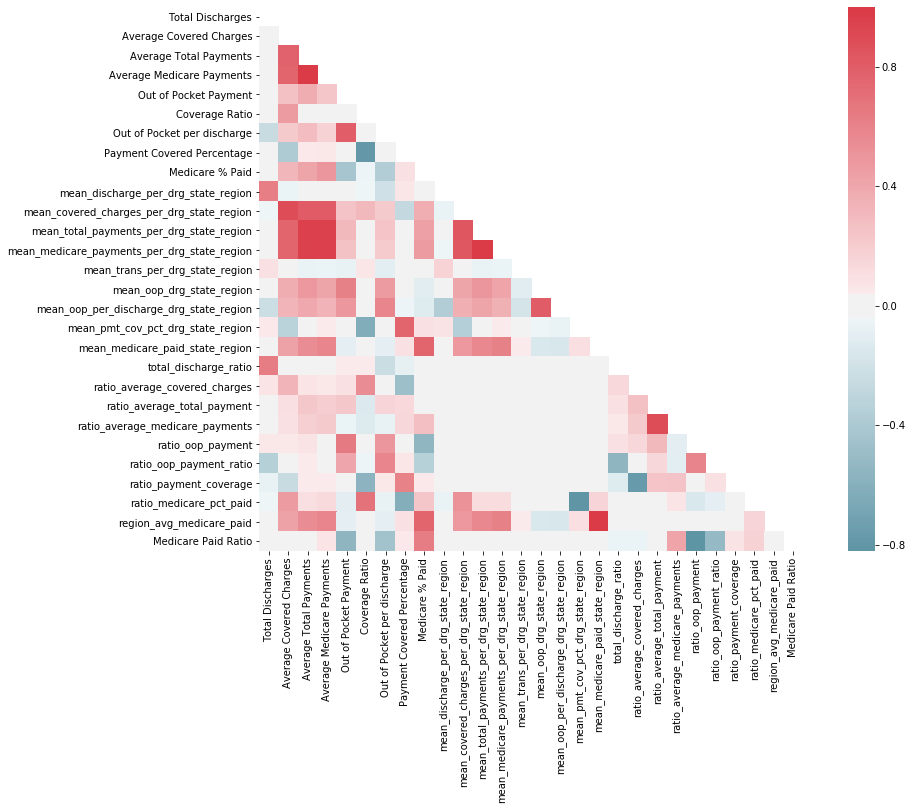

In [13]:
fig = plt.figure(figsize=(16,10))
corr = k_means_data_scaled.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True)
plt.show()

## K Means

The degree of multicollinearity introduces a problem. Not all these features will be relevant, and those attributes that are irrelevant to the problem need to be removed. There will be some features that will be more important than others and there will also be features that will be redundant in the context of other features. I address this issue by removing the features with more than 0.5 correlation, to narrow down the data. 

In [14]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset

In [15]:
km_data_1 = correlation(k_means_data_scaled, 0.5)
print(f' There are {len(km_data_1.columns)} columns remaining in the data')
km_data_1.head()

 There are 7 columns remaining in the data


,Total Discharges,Average Covered Charges,Out of Pocket Payment,Payment Covered Percentage,mean_trans_per_drg_state_region,ratio_average_total_payment,Medicare Paid Ratio
0,0.943640,32963.07,1013.51,0.175264,2,1.037810,1.000954
1,-0.563094,15131.85,810.86,0.382476,13,1.008540,1.069224
2,-0.367414,37560.37,981.16,0.144699,13,0.947092,1.018959
3,-0.347846,13998.28,1288.40,0.387016,13,0.944062,0.947721
4,-0.484822,31633.27,806.89,0.178873,13,0.986018,1.066118




Determining the optimal number of clusters is a fundamental issue for k means clustering. There is no definitive answer and its domain-specific.  Domain knowledge can be used to inform the right number of clusters, or you can use the elbow method to determine the correct number of clusters. 

By analyzing the elbow method below, it would seem that it stops improving at around 5. 


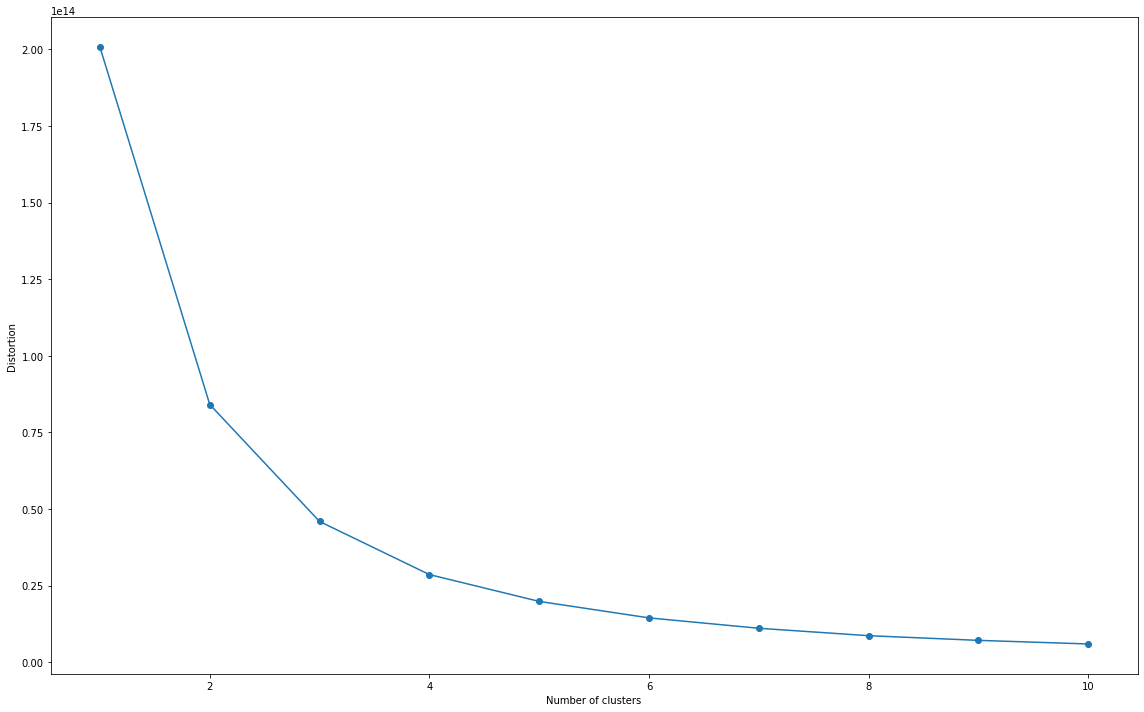

In [16]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(km_data_1)
    distortions.append(km.inertia_)

# plot
fig = plt.figure(figsize=(16,10))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [17]:
km_1 = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

In [18]:
charge_data_2['K Means 1'] = km_1.fit_predict(km_data_1)

In [19]:
def kmean_prop(data, column): 
    data_value = data.groupby(column).agg(count = pd.NamedAgg(column= column, aggfunc= 'count'))
    percentage = []
    for i in range(0, len(data_value)): 
        result = round(((data_value.iloc[i,0] / len(data)) * 100),2)
         
        percentage.append(result)
    data_value['percentage (%)'] = percentage
        
    return data_value

I've categorized and counted the occurence in each cluster. I'm estimating that cluster 2 are the fraud cases and merit further investigation: represents ~ 1% of all cases. 

In [20]:
kmean_prop(charge_data_2, 'K Means 1')

,count,percentage (%)
K Means 1,,
0,45212,27.73
1,4988,3.06
2,891,0.55
3,94973,58.24
4,17001,10.43


Add the new kluster to the original data to understand the key patterns in the data. 

In [21]:
km_1_columns = km_data_1.columns
km_merged_data_km_1 = charge_data_2.loc[:,km_1_columns]
km_merged_data_km_1.head()

,Total Discharges,Average Covered Charges,Out of Pocket Payment,Payment Covered Percentage,mean_trans_per_drg_state_region,ratio_average_total_payment,Medicare Paid Ratio
0,91,32963.07,1013.51,0.175264,2,1.037810,1.000954
1,14,15131.85,810.86,0.382476,13,1.008540,1.069224
2,24,37560.37,981.16,0.144699,13,0.947092,1.018959
3,25,13998.28,1288.40,0.387016,13,0.944062,0.947721
4,18,31633.27,806.89,0.178873,13,0.986018,1.066118


By plotting the results some distinct patterns begin to emerge for the 2 cluster. 
 - low discharge but high covered charges 
 - low out of pocket payments and high covered charges
 - Medicare paid ratio between 0.8 and 1.2 
 
By taking a step back, it makes sense that those features would indicate fraudulent activity. My hypothesis of of high average charges and low out of pocket payment seems like it was a useful suggestions. 

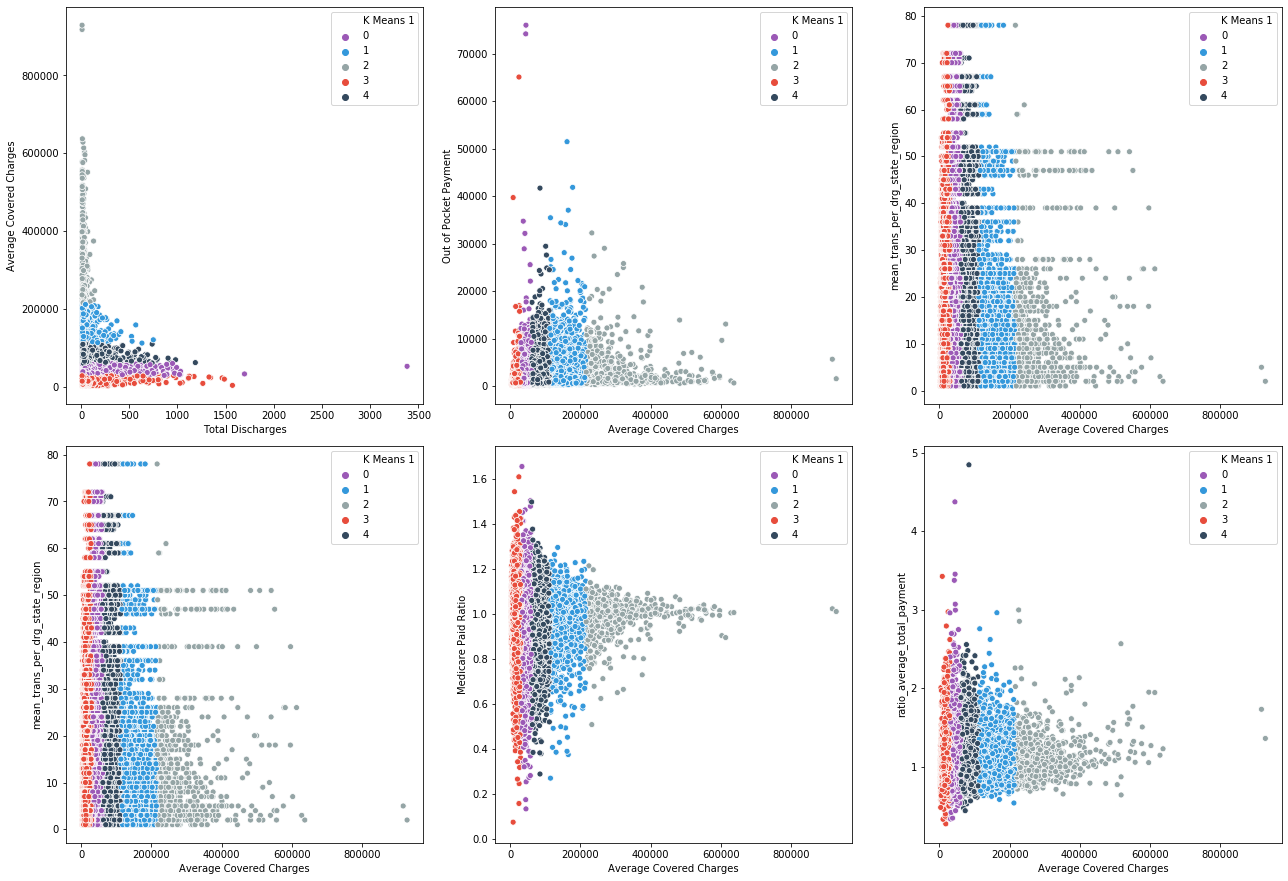

In [22]:
plt.figure(figsize=(18, 18))
plt.subplot(3,3,1)

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e"]
sns.scatterplot(x = 'Total Discharges', y = 'Average Covered Charges', hue = 'K Means 1',data = charge_data_2, palette=flatui)

plt.subplot(3,3,2)
sns.scatterplot(x = 'Average Covered Charges', y = 'Out of Pocket Payment', hue = 'K Means 1',data = charge_data_2, palette=flatui)

plt.subplot(3,3,3)
sns.scatterplot(x = 'Average Covered Charges', y = 'mean_trans_per_drg_state_region', hue = 'K Means 1',data = charge_data_2, palette=flatui)

plt.subplot(3,3,4)
sns.scatterplot(x = 'Average Covered Charges', y = 'mean_trans_per_drg_state_region', hue = 'K Means 1',data = charge_data_2, palette=flatui)

plt.subplot(3,3,5)
sns.scatterplot(x = 'Average Covered Charges', y = 'Medicare Paid Ratio', hue = 'K Means 1',data = charge_data_2, palette=flatui)

plt.subplot(3,3,6)
sns.scatterplot(x = 'Average Covered Charges', y = 'ratio_average_total_payment', hue = 'K Means 1',data = charge_data_2, palette=flatui)
plt.tight_layout()
plt.show()

In [23]:
fraud_list = charge_data_2 [charge_data_2['K Means 1'] == 2]
fraud_list.head()

,DRG Definition,Provider Id,Provider Name,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,...,ratio_average_covered_charges,ratio_average_total_payment,ratio_average_medicare_payments,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,region_avg_medicare_paid,Medicare Paid Ratio,K Means 1
2483,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,50464,DOCTORS MEDICAL CENTER,MODESTO,CA,95350,CA - Modesto,38,232751.36,18404.44,...,1.749554,1.062603,1.054916,1.193594,0.787631,0.497611,5.901169,0.943428,0.993962,2
3609,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,390180,CROZER CHESTER MEDICAL CENTER,UPLAND,PA,19013,PA - Philadelphia,38,225088.00,16539.92,...,2.322224,1.159778,1.180160,0.880748,0.563848,0.424821,5.482416,0.927731,1.022175,2
3630,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,390290,HAHNEMANN UNIVERSITY HOSPITAL,PHILADELPHIA,PA,19102,PA - Philadelphia,20,234912.70,23126.15,...,2.423585,1.621604,1.664827,1.029888,1.252719,0.569143,5.531338,0.927731,1.031296,2
15187,177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W...,50737,GARFIELD MEDICAL CENTER,MONTEREY PARK,CA,91754,CA - Los Angeles,58,217988.75,24577.89,...,2.102957,1.332408,1.343223,1.110688,0.596737,0.543257,4.631511,0.952440,1.009231,2
16413,177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W...,390180,CROZER CHESTER MEDICAL CENTER,UPLAND,PA,19013,PA - Philadelphia,40,232552.37,17313.60,...,2.517853,1.159482,1.191972,0.639721,0.423113,0.391258,5.084709,0.936466,1.033183,2


In [24]:
print(f' The fraud list contains {len(fraud_list.groupby("Provider Name").count())} providers who performed {len(fraud_list.groupby("DRG Definition").count())}  procedures accross {len(fraud_list.groupby("Provider State").count())}  states')

 The fraud list contains 349 providers who performed 24  procedures accross 31  states


In [25]:
fraud_list.iloc[:,7:16].head()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid
2483,38,232751.36,18404.44,17258.42,1146.02,12.646479,30.158421,0.079073,0.937731
3609,38,225088.00,16539.92,15684.86,855.06,13.608772,22.501579,0.073482,0.948303
3630,20,234912.70,23126.15,22126.30,999.85,10.157882,49.992500,0.098446,0.956765
15187,58,217988.75,24577.89,23625.05,952.84,8.869303,16.428276,0.112748,0.961232
16413,40,232552.37,17313.60,16751.62,561.98,13.431774,14.049500,0.074450,0.967541


The identified fraudulent cases seem to be prevelant in a handful of procedures, a small number makes up a large proportion of the cases. 

In [26]:
fraud_list.groupby(drg_defination_name).agg(count = pd.NamedAgg(column = drg_defination_name, aggfunc = 'count')).sort_values(by= 'count', ascending= False)

,count
DRG Definition,
870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,200
329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,196
853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC,182
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,171
460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,33
246 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT W MCC OR 4+ VESSELS/STENTS,18
208 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT <96 HOURS,15
252 - OTHER VASCULAR PROCEDURES W MCC,15
480 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOINT W MCC,10


In [27]:
fraud_list.groupby(provider_state_name).agg(count = pd.NamedAgg(column = provider_state_name, aggfunc = 'count')).sort_values(by= 'count', ascending= False)

,count
Provider State,
CA,411
NJ,96
FL,75
PA,67
TX,64
NV,34
NY,17
AL,14
IL,12
